<a href="https://colab.research.google.com/github/patrickphatnguyen/Image-Captioning-Attention/blob/master/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Import libraries

In [0]:
import os
import tensorflow as tf

In [0]:
data_path = os.path.abspath('.') + "/drive/My Drive/Image-Captioning/"
image_path = data_path +'coco2014/'

# Download files

In [13]:
# Grab the captions file & extract
# captions_zip = tf.keras.utils.get_file('captions.zip',
#                                           cache_subdir=data_path,
#                                           origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
#                                           extract = True)
# os.remove(os.path.join(data_path,"captions.zip"))

name_of_zip = 'coco2014.zip'

if not os.path.exists(data_path + name_of_zip):
  # Grab the train data & extract
  train_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=data_path,
                                      origin = 'http://images.cocodataset.org/zips/val2014.zip',
                                      extract = True)
  # Remove after extracted 
  os.remove(os.path.join(data_path,name_of_zip))

  
  PATH = os.path.dirname(data_path)+'/coco2014'
else:
  PATH = os.path.abspath('.')+'/coco2014/'

6645014528/6645013297 [==============================] - 277s 0us/step


# Load data

In [0]:
caption_file = data_path + 'annotations/captions_val2014.json'
image_path = data_path + 'val2014/'

In [0]:
import json
with open(caption_file,'r') as f:
  caption_json = json.load(f)

In [34]:
for data in caption_json['annotations']:

[{'caption': 'A bicycle replica with a clock as the front wheel.',
  'id': 37,
  'image_id': 203564},
 {'caption': 'A black Honda motorcycle parked in front of a garage.',
  'id': 38,
  'image_id': 179765},
 {'caption': 'A room with blue walls and a white sink and door.',
  'id': 49,
  'image_id': 322141},
 {'caption': 'A car that seems to be parked illegally behind a legally parked car',
  'id': 89,
  'image_id': 16977},
 {'caption': 'A large passenger airplane flying through the air.',
  'id': 98,
  'image_id': 106140},
 {'caption': 'There is a GOL plane taking off in a partly cloudy sky.',
  'id': 101,
  'image_id': 106140},
 {'caption': 'Blue and white color scheme in a small bathroom.',
  'id': 109,
  'image_id': 322141},
 {'caption': 'This is a blue and white bathroom with a wall sink and a lifesaver on the wall.',
  'id': 121,
  'image_id': 322141},
 {'caption': 'A blue boat themed bathroom with a life preserver on the wall',
  'id': 163,
  'image_id': 322141},
 {'caption': 'The

In [5]:
for data in caption_json['annotations']:
  if data['image_id'] == 462805:
    print(data['caption'])

Two people, one on skis and one on a snowboard are standing in snow.
A pair of snow skis and a snowboard in the snow.
A view of people's feet and equipment as they prepare for winter sports in the snow.
a snowboarder and a snow skiers legs and snow
A man riding a snowboard next to a person in skis.


In [62]:
from tqdm import tqdm
# We create a dictionary that map image path to its caption
image_caption_dict = {}

# Add image, url to a
def image_caption_to_dict(image_url,caption,mDict):
  # If image url in dict keys
  if image_url in mDict.keys():
    # Append the caption to the list in dict corresponding to the image 
    mDict[image_url].append(caption)
  else:
    # Create a new key and add a list with the 
    mDict[image_url] = [caption]
  return mDict
    
for json_line in tqdm(caption_json['annotations']):
  # Get the image id of that json line
  image_id = str(json_line['image_id'])
  # Calculate len of the id
  len_id = len(image_id)
  # construct an image url by add zeros and .
  image_url = image_path+'COCO_val2014_'+'0'*(12-len_id) + image_id + '.jpg' 
  
  caption = json_line['caption']
  image_caption_to_dict(image_url,caption,image_caption_dict)
 


100%|██████████| 202654/202654 [00:00<00:00, 458715.25it/s]

A bath tub sitting next to a white toilet.
A carpeted bathroom with a tub and shower and a toilet.
THERE IS A TUB AND TOILET IN THE BATHROOM
A simple hotel bathroom with toilet and bath tub.
This bathroom has shiny marble floors on it.


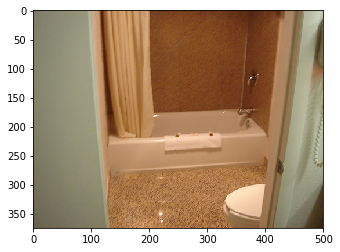

In [70]:
idx = 15
that_image_url = image_path + os.listdir(image_path)[idx]
plt.imshow(Image.open(that_image_url))
captions = image_caption_dict[that_image_url]
for caption in captions:
  print(caption)